<a href="https://colab.research.google.com/github/lphansen/QuantMFR/blob/notebook_chapters/uncertainty_expansion/example_simple_expanded_checkpoint_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uncertain Expansion Example Notebook

# 1 Preliminaries <a class="anchor" id="s2"></a>

## 1.1 Model Setup
The general structure for models to be solved using the expansion code can be written as:
```{math}
:label: triangle
\begin{align}
X_{t+1} \left( \mathsf{q} \right) =  & \hspace{.2cm} \psi^x \left[D_t \left( \mathsf{q} \right), X_{t} \left( \mathsf{q} \right), {\sf q} W_{t+1}, {\sf q} \right], \cr
\log G_{t+1} \left( \mathsf{q} \right) - \log G_t \left( \mathsf{q} \right) = & \hspace{.2cm} \psi^g \left[ D_t \left( \mathsf{q} \right), X_{t} \left( \mathsf{q},
 \right), {\sf q} W_{t+1}, {\sf q}  \right], \cr
{\widehat C}_t \left( \mathsf{q} \right)  = & \hspace{.2cm} \kappa \left[D_t \left( \mathsf{q} \right), X_{t} \left( \mathsf{q}  \right) \right] + {\widehat G}_t \left( \mathsf{q} \right).
\end{align}
```
In addition, there are a set of first-order conditions and co-state equations detailed in Chapter 8 of the book. These are compiled automatically by the code.


## 1.2 Inputs

The `Expansion Suite` uses the function `uncertain_expansion` to approximate a solution to the above system locally. The user must specify several sets of inputs. Define the relevant variables:

```{list-table}
:header-rows: 1

* - Input
  - Description
  - Notation in text
* - `control_variables`
  - Variables chosen by the decision-maker at time $t$
  - $D_t$
* - `state_variables`
  - Variables that describe the current state of the system
  - $X_t$
* - `shock_variables`
  - Variables representing different entries of the Brownian motion variable
  - $W_t$
```
The $t+1$ variables will be automatically created from this. For example, if a state variable is inputted as `Z_t`, an additional state variable `Z_tp1` will be automatically generated. 
We also need to define the equilibrium conditions:
```{list-table}
:header-rows: 1

* - Input
  - Description
  - Notation in text
* - `kappa`
  - Log share of capital not allocated to consumption
  - $\kappa(X_t(q),D_t(q))$
* - `growth`
  - Law of motion for $\hat{G}_{t+1}-\hat{G}_t$
  - $\psi^g(D_t(q),X_t(q),qW_{t+1},q)$
* - `state_equations`
  - Law of motion for state variables
  - $\psi^x(D_t(q),X_t(q),qW_{t+1},q)$
```
The remaining equilibrium conditions will be automatically computed by the code. The user must also define a list of parameters and their corresponding values. This can be done by specifying pairs of inputs such as `beta = 0.99` or `gamma = 1.01` within the body of the function `create_args`. 

Note that the user must define the variables and parameters *before* defining the equations. Make sure that the **equations use the same expressions for variables and parameters** as previously defined by the user. 

The output is of class `ModelSolution`, which stores the coefficients for the linear-quadratic approximation for the jump and state variables; continuation values; consumption growth; and log change of measure, as well as the steady-state values of each variables. 


<br>

# 2 Example
We will now walk through the computation using the example above. Begin by installing the following libraries and downloading `RiskUncertaintyValue`, which contains the functions required to solve the model:

In [23]:
import os
import sys
import sympy as sp
workdir = os.getcwd()
!git clone https://github.com/lphansen/RiskUncertaintyValue 
workdir = os.getcwd() + '/RiskUncertaintyValue_automatic'             
sys.path.insert(0, workdir+'/src')                        
import numpy as np
import seaborn as sns
import autograd.numpy as anp
from scipy import optimize
np.set_printoptions(suppress=True)
np.set_printoptions(linewidth=200)
from IPython.display import display, HTML
from BY_example_sol import disp
display(HTML("<style>.container { width:97% !important; }</style>"))
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from scipy.stats import norm

from lin_quad import LinQuadVar
from lin_quad_util import E, concat, next_period, cal_E_ww, lq_sum, N_tilde_measure, E_N_tp1, log_E_exp, kron_prod, distance
from utilities import mat, vec, sym
from uncertain_expansion import uncertain_expansion, generate_symbols_and_args, compile_equations, get_parameter_value
from elasticity import exposure_elasticity, price_elasticity
from plot import plot_exposure_elasticity, plot_price_elasticity
np.set_printoptions(suppress=True)
import pickle
import pandas as pd
from scipy.optimize import fsolve
import sympy as sp

fatal: destination path 'RiskUncertaintyValue' already exists and is not an empty directory.


## 2.1 Parameters
Use the following function to define and set the values for your parameters.

In [24]:
def create_args():
    # Define parameters here
    sigma_k1 = 0.92 * anp.sqrt(12)
    sigma_k2 = 0.4 * anp.sqrt(12)
    sigma_k3 = 0.0
    sigma_z1 = 0.0
    sigma_z2 = 5.7 * anp.sqrt(12)
    sigma_z3 = 0.0
    sigma_y1 = 0.0
    sigma_y2 = 0.0
    sigma_y3 = 0.00031 * anp.sqrt(12)
    
    # Base parameters
    delta = 0.01
    a = 0.0922
    epsilon = 1.0
    gamma = 8.0                        #Do not change this name
    rho = 1.5                            #Do not change this name
    beta = anp.exp(-epsilon * delta)     #Do not change this name
    
    # Capital evolution parameters
    phi_1 = 1 / 8
    phi_2 = 8.0
    beta_k = 0.04
    alpha_k = 0.04
    
    # Other states
    beta_z = 0.056
    beta_2 = 0.194
    mu_2 = 6.3 * (10**(-6))
    
    # Return as a dictionary
    return locals()



## 2.2 Variables
Define your variables as below. You may only have one growth variable and one perturbation variable. Apart from this, you may add more variables to the list as you wish.

In [25]:
# Define variable names
control_variables = ["imk_t"]
state_variables = ["Z_t", "Y_t"]
growth_variables = ["log_gk_t"]
perturbation_variable = ["q_t"]
shock_variables = ["W1_t", "W2_t", "W3_t"]

The user does not need to change the following code, which creates symbols for the defined parameters and variables. 

In [26]:
parameter_names, args = generate_symbols_and_args(create_args)
globals().update(parameter_names)
variables = control_variables + state_variables + growth_variables + perturbation_variable + shock_variables
variables_tp1 = [var + "p1" for var in variables]
symbols = {var: sp.Symbol(var) for var in variables + variables_tp1}
globals().update(symbols)  

## 2.3 Define Equilibrium Conditions
Ensure that you use the same names for your variables and parameters from before. You must have one output constraint and one capital growth equation, but you may add as many state equations as you wish. The first-order conditions and co-state equations will be automatically handled and do not need to be specified.

In [27]:
# Output constraint
kappa = sp.log(a - imk_t)

# Capital growth equation
growth = epsilon * (phi_1 * sp.log(1. + phi_2 * imk_t) - alpha_k + beta_k * Z_t \
                      - q_t**2 * 0.5 * (sigma_k1**2 + sigma_k2**2 + sigma_k3**2) * sp.exp(Y_t)) \
                      + sp.sqrt(epsilon) * sp.exp(0.5 * Y_t) * (sigma_k1 * W1_tp1 + sigma_k2 * W2_tp1 + sigma_k3 * W3_tp1)       

# Technology growth equation
technology_growth = Z_tp1 - Z_t + epsilon * beta_z * Z_t \
                                - sp.sqrt(epsilon) * sp.exp(0.5 * Y_t) * (sigma_z1 * W1_tp1 + sigma_z2 * W2_tp1 + sigma_z3 * W3_tp1)

# Volatility growth equation
volatility_growth = Y_tp1 - Y_t + epsilon * beta_2 * (1 - mu_2 * sp.exp(-Y_t)) \
                          + q_t**2 * 0.5 * (sigma_y1**2 + sigma_y2**2 + sigma_y3**2) * sp.exp(-Y_t) * epsilon \
                          - sp.exp(-0.5 * Y_t) * (sigma_y1 * W1_tp1 + sigma_y2 * W2_tp1 + sigma_y3 * W3_tp1) * sp.sqrt(epsilon)

# State equations
state_equations = [technology_growth, volatility_growth]


## 2.4 Code Settings
You may additionally set the following:
* **Initial guess** for steady-state variables. This must have the same length as the number of variables
* **Recursive terms initialization**. These are initializations for terms like $\log N_t^*$ and $\hat{R}_t-\hat{V}_t$, which may be loaded from a previous solution.
* **Convergence tolerance**. How small the maximum error across the approximated terms must be before the algorithm is considered to have converged.
* **Maximum iterations**. The maximum number of iterations for the algorithm can take.
* **Save location**. Save the model solution to this location so that it can be accessed later.

In [28]:
initial_guess = np.concatenate([np.array([-2.1968994 ,  -4.123193  ,  anp.exp(-2.57692626)]),np.ones(3),np.array([0.01937842, 0.        , -11.97496092])])
savepath='output/res.pkl'
savepath = None
init_util = None
iter_tol = 1e-5
max_iter = 50

#Code for loading pre-solution
# with open(savepath,'rb') as f:
#     preload = pickle.load(f)
# init_util = preload['util_sol']

## 2.5 Run Code
You are now ready to run the function `uncertain_expansion`. You do not need to change anything in the following code.

In [29]:
ModelSol = uncertain_expansion(control_variables, state_variables, shock_variables, variables, variables_tp1,
                    kappa, growth, state_equations, initial_guess, parameter_names,
                    args, approach = '1', init_util = init_util, iter_tol = iter_tol, max_iter = max_iter,savepath=savepath)

[-beta*exp(rmv_t*(1 - rho)) - (1 - beta)*exp(log_cmk_t*(1 - rho))*exp(-vmk_t*(1 - rho)) + 1.0, log_cmk_t - log(a - imk_t), beta*epsilon*mg_tp1*phi_1*phi_2*exp(rmv_t*(1 - rho))/(imk_t*phi_2 + 1.0) - (1 - beta)*exp(log_cmk_t*(1 - rho))*exp(-vmk_t*(1 - rho))/(a - imk_t), beta*(beta_k*epsilon*mg_tp1 + m0_tp1*(beta_z*epsilon - 1))*exp(rmv_t*(1 - rho)) - m0_t, beta*(-0.5*sqrt(epsilon)*m0_tp1*(W1_tp1*sigma_z1 + W2_tp1*sigma_z2 + W3_tp1*sigma_z3)*exp(0.5*Y_t) + m1_tp1*(beta_2*epsilon*mu_2*exp(-Y_t) + 0.5*sqrt(epsilon)*(W1_tp1*sigma_y1 + W2_tp1*sigma_y2 + W3_tp1*sigma_y3)*exp(-0.5*Y_t) - 0.5*epsilon*q_t**2*(sigma_y1**2 + sigma_y2**2 + sigma_y3**2)*exp(-Y_t) - 1) + mg_tp1*(0.5*sqrt(epsilon)*(W1_tp1*sigma_k1 + W2_tp1*sigma_k2 + W3_tp1*sigma_k3)*exp(0.5*Y_t) - 0.5*epsilon*q_t**2*(sigma_k1**2 + sigma_k2**2 + sigma_k3**2)*exp(Y_t)))*exp(rmv_t*(1 - rho)) - m1_t, 1.0*beta*mg_tp1*exp(rmv_t*(1 - rho)) - mg_t + 1.0*(1 - beta)*exp(log_cmk_t*(1 - rho))*exp(-vmk_t*(1 - rho)), -sqrt(epsilon)*(W1_tp1*sigma_k1

## 2.6 Plot Elasticities

First, if you did not run the code above, you can load a pre-solved solution by specifying `save_path` as follows:

In [10]:
savepath='output/res.pkl'
with open(savepath,'rb') as f:
    ModelSol = pickle.load(f)

We use `plot_exposure_elasticity` to plot exposure elasticities.
* `quantile` specifies the quantiles to be plotted
* `T` specifies the number of periods (using the time-unit that you specified the parameters in)
* (optional) The `ylim` parameters are for setting the upper limits for the y axes

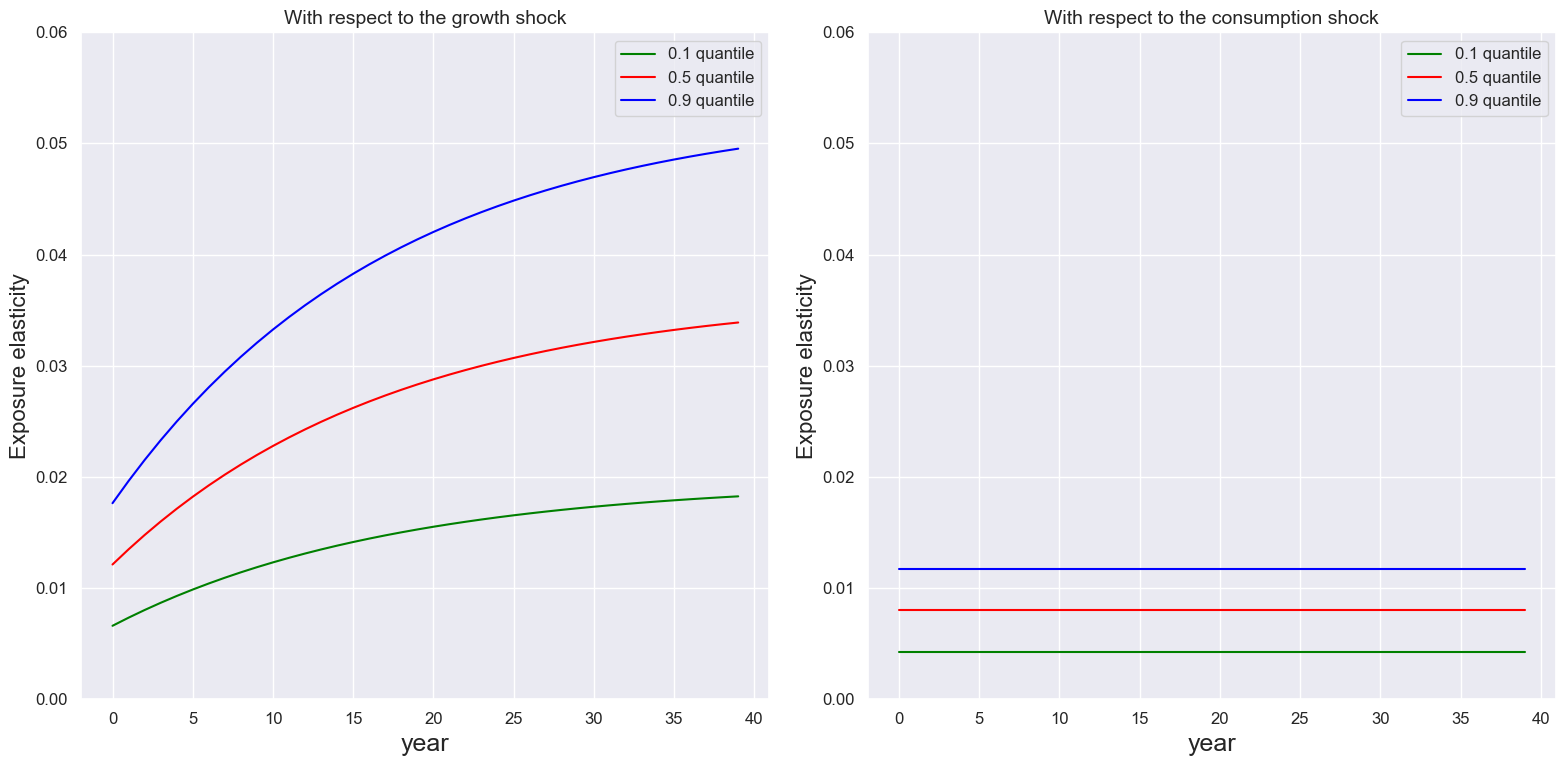

In [30]:
quantile = [0.1,0.5,0.9]
T = 40
ylim1, ylim2 = 0.06, 0.06
plot_exposure_elasticity(ModelSol,T,quantile,'year',ylim1, ylim2)

Similarly we can plot the price elasticities using `price_elasticity`.

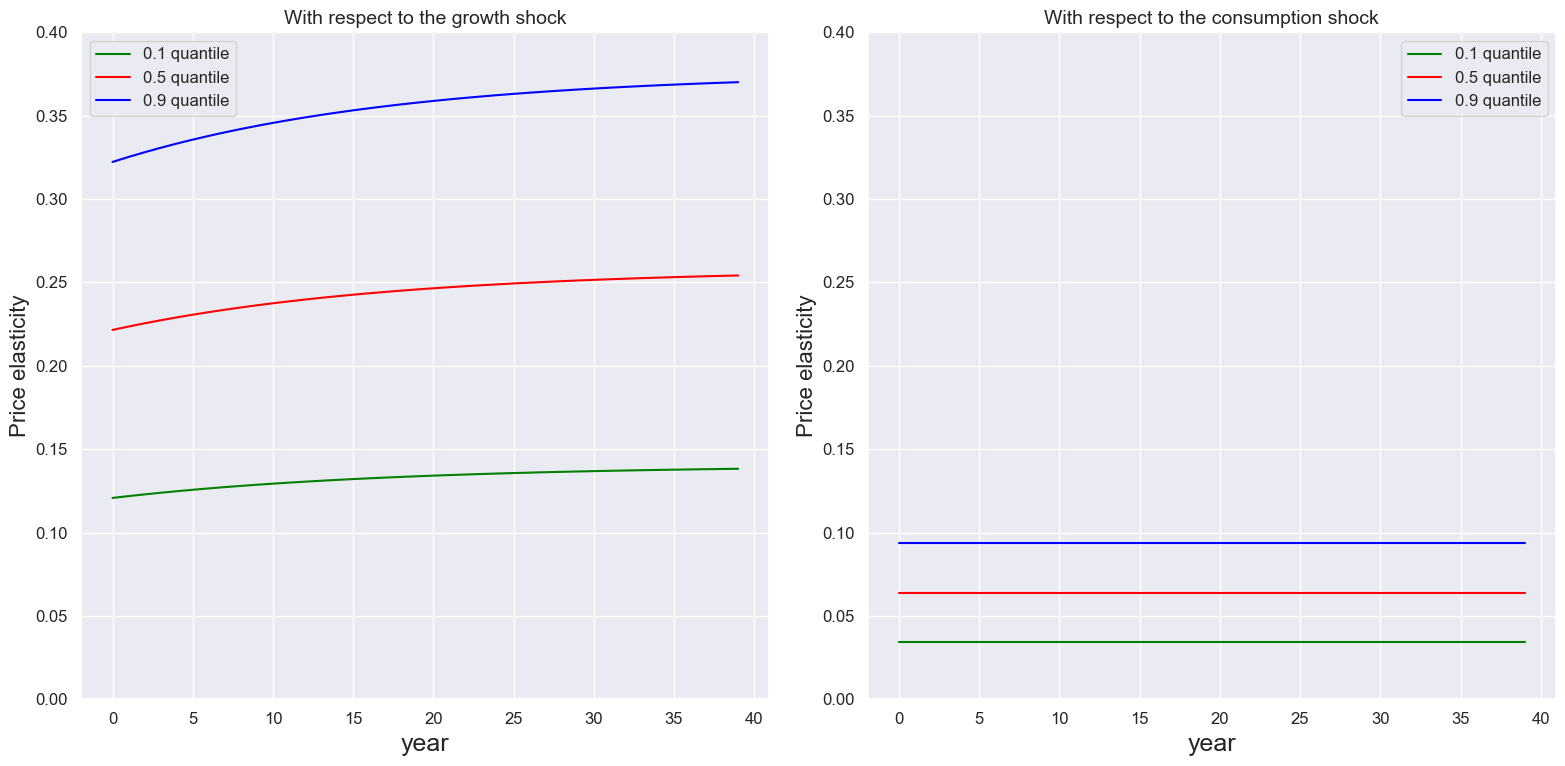

In [9]:
quantile = [0.1,0.5,0.9]
T = 40
ylim1, ylim2 = 0.4, 0.4
plot_price_elasticity(ModelSol,T,quantile,'year',ylim1, ylim2)

<br>
<br>
<br>

# 3 Outputs

## 3.1 List of Outputs <a class="anchor" id="s3-1"></a>

We now examine the contents of `ModelSol`, which contains the attributes listed below. Each approximation is stored in a class `LinQuadVar`, which contains the coefficients for $X_{1,t}, X_{2,t}, X_{1,t}'X_{1,t}, W_{t+\epsilon}, W_{t+\epsilon}'W_{t+\epsilon}, X_{1,t}'W_{t+\epsilon}$ and the constant.


```{list-table}
:header-rows: 1

* - Input
  - Type
  - Description
* - `JXn_t`
  - *LinQuadVar*
  - Approximation of jump and state variables at time $t$. Replace `n` with `0,1,2` to get the zeroth, first and second-order contribution. Omit `n` to get the full approximation. The variables are indexed in the order specified in Section 2. 
* - `Jn_t`
  - *LinQuadVar*
  - Same as `JXn_t` but limited to jump variables.
* - `Xn_tp1`
  - *LinQuadVar*
  - Same as `JXn_t` but limited to state variables.
* - `JXn_t_tilde`
  - *LinQuadVar*
  - Same as `JXn_t` but using distorted measure. This variation is also available for `Jn_t` and `Xn_tp1`.
* - `util_sol`
  - *dict*
  - Dictionary containing solutions of the continuation values, including $\mu^0, \Upsilon_0^2, \Upsilon_1^2,$ and $\Upsilon_2^2$ etc.
* - `vmrn_tp1`
  - *LinQuadVar*
  - Approximation of continuation values $\widehat{V}^1_{t+\epsilon}-\widehat{R}^1_t$ . Replace `n` with `0,1,2` to get the zeroth, first and second-order contribution. Omit `n` to get the full approximation. 
* - `gcn_tp1`
  - *LinQuadVar*
  - Approximation of consumption growth $\widehat{C}_{t+\epsilon}-\widehat{C}_t$ . Replace `n` with `0,1,2` to get the zeroth, first and second-order contribution. Omit `n` to get the full approximation. 
* - `ss`
  - *dict*
  - Steady states for state and jump variables
* - `log_N_tilde`
  - *LinQuadVar*
  - Approximation for the log change of measure
```

For example, we can obtain the coefficients for the first-order contribution of $\log{C_t/K_t}$ in the following way, noting that `cmk_t` was listed as the first jump variable when we specified the equilibrum conditions.


In [17]:
## Log consumption over capital approximation results, shown in the LinQuadVar coefficients form
ModelSol['JX1_t'][0].coeffs

{'x': array([[-0.        ,  0.17006158, -0.        ]]),
 'c': array([[-0.06496613]])}

We can also display the full second-order approximation of $\log{C_t/K_t}$ using the `disp` function, which renders a `LinQuadVar` object in LATEX form.

In [18]:
## Log consumption over capital approximation results, shown in the Latex analytical form
disp(ModelSol['JX_t'][0],'\\log\\frac{C_t}{K_t}') 

<IPython.core.display.Math object>

Another example:

In [19]:
## Log capital growth process second order approximation results
disp(ModelSol['X2_tp1'][0],'\\log\\frac{K_{t+\epsilon}^2}{K_t^2}') 

<IPython.core.display.Math object>

<br>

## 3.2 Simulate Variables <a class="anchor" id="s3-3"></a>
Given a series of shock processes, we can simulate the path of our state and jump variables using the `ModelSolution.simulate` method. Here, we simulate 400 periods of i.i.d standard multivariate normal shocks.

In [ ]:
Ws = np.random.multivariate_normal(np.zeros(n_W),np.eye(n_W),size = 400)
JX_sim = ModelSol.simulate(Ws)

<br>
<br>

# 4 Using `LinQuadVar` in Computation <a class="anchor" id="s2"></a>

In the previous section, we saw how to use `uncertain_expansion` to approximate variables and store their coefficients as `LinQuadVar` objects. In this section, we explore how to manipulate `LinQuadVar` objects for different uses.

To aid our examples, we first extract the steady states for the state evolution processes from the previous model solution:

See [src/lin_quad.py](https://github.com/lphansen/RiskUncertaintyValue/blob/main/src/lin_quad.py) for source code of `LinQuadVar` definition.

In [22]:
ModelSol['ss']

array([ -3.66035793,   0.0664767 ,   0.02039991,   0.        ,   1.        ,   0.01330655,   0.        , -11.97496092])

In [23]:
n_J, n_X, n_W = ModelSol['var_shape']
X0_tp1 = LinQuadVar({'c':np.array([[ModelSol['ss'][0]],[ModelSol['ss'][1]],[ModelSol['ss'][2]]])}, shape = (n_X, n_X, n_W))

## 4.1 `LinQuadVar` Operations <a class="anchor" id="s4-1"></a>
We can sum multiple LinQuads together in two different ways. Here we demonstrate this with an example by summing the zeroth, first and second order contributions of our approximation for capital growth. 

In [24]:
gk_tp1 = X0_tp1[0] + ModelSol['X1_tp1'][0]  + 0.5 * ModelSol['X2_tp1'][0] 
disp(gk_tp1,'\\log\\frac{K_{t+\epsilon}}{K_t}') 

<IPython.core.display.Math object>

In the next example, we sum together the contributions for both capital growth and technology:

In [25]:
lq_sum([X0_tp1, ModelSol['X1_tp1'], 0.5 * ModelSol['X2_tp1']]).coeffs

{'xw': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.00399962,  0.00173897,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.02478025,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        , -0.21392032]]),
 'c': array([[-3.65924752],
        [ 0.0664767 ],
        [-0.0711239 ]]),
 'xx': array([[-0.        , -0.        ,  0.        , -0.        , -0.00021926,  0.        , -0.        , -0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.097     ]]),
 'x2': array([[-0.       ,  0.0185721,  0.       ],
        [ 0.       ,  0.472    ,  0.       ],
        [ 0.       ,  0.       ,  0.403    ]]),


## 4.2 `LinQuadVar` Split and Concat <a class="anchor" id="s4-2"></a>
`split` breaks multiple dimensional LinQuad into one-dimensional LinQuads, while `concat` does the inverse.

In [26]:
gk_tp1, Z_tp1, Y_tp1 = ModelSol['X1_tp1'].split()
concat([gk_tp1, Z_tp1, Y_tp1])

## 4.3 Evaluate a `LinQuadVar` <a class="anchor" id="s4-3"></a>
We can evaluate a LinQuad at specific state $(X_{t},W_{t+\epsilon})$ in time. As an example, we evaluate all 5 variables under steady state with a multivariate random normal shock.

In [27]:
x1 = np.zeros([n_X ,1])
x2 = np.zeros([n_X ,1])
w = np.random.multivariate_normal(np.zeros(n_W),np.eye(n_W),size = 1).T
ModelSol['JX_tp1'](*(x1,x2,w))

array([[ -3.71818036],
       [  0.06792475],
       [  0.02041077],
       [ -0.00013651],
       [  0.99999734],
       [  0.01454234],
       [  0.05682728],
       [-12.65749319]])

## 4.4 Next period expression for `LinQuadVar` <a class="anchor" id="s4-4"></a>
`ModelSol` allows us to express a jump variable $J_t$ as a function of $t$ state and shock variables. Suppose we would like to compute its next period expression $J_{t+\epsilon}$ with shocks. The function `next_period` expresses $J_{t+\epsilon}$ in terms of $t$ state variables and $t+\epsilon$ shock variables. For example, we can express the $t+\epsilon$ expression for the first-order contribution to consumption over capital as:

In [28]:
cmk1_tp1 = next_period(ModelSol['J1_t'][0], ModelSol['X1_tp1'])
disp(cmk1_tp1, '\\log\\frac{C_{t+\epsilon}^1}{K_{t+\epsilon}^1}') 

<IPython.core.display.Math object>

In [29]:
cmk2_tp1 = next_period(ModelSol['J2_t'][0], ModelSol['X1_tp1'], ModelSol['X2_tp1'])
disp(cmk2_tp1, '\\log\\frac{C_{t+\epsilon}^2}{K_{t+\epsilon}^2}') 

<IPython.core.display.Math object>

## 4.6 Compute the Expectation of time $t+\epsilon$ `LinQuadVar` <a class="anchor" id="s4-6"></a>

Suppose the distribution of shocks has a constant mean and variance (not state dependent). Then, we can use the `E` function to compute the expectation of a time $t+\epsilon$ `LinQuadVar` as follows:


In [30]:
E_w = ModelSol['util_sol']['μ_0']
cov_w = np.eye(n_W)
E_ww = cal_E_ww(E_w, cov_w)
E_cmk2_tp1 = E(cmk2_tp1, E_w, E_ww)
disp(E_cmk2_tp1, '\mathbb{E}[\\log\\frac{C_{t+\epsilon}^2}{K_{t+\epsilon}^2}|\mathfrak{F_t}]')

<IPython.core.display.Math object>

Suppose the distribution of shock has a state-dependent mean and variance (implied by $\tilde{N}_{t+\epsilon}$ shown in the notes), we can use `E_N_tp1` and `N_tilde_measure` to compute the expectation of time $t+\epsilon$ `LinQuadVar`.

In [31]:
N_cm = N_tilde_measure(ModelSol['util_sol']['log_N_tilde'],(1,n_X,n_W))
E_cmk2_tp1_tilde = E_N_tp1(cmk2_tp1, N_cm)
disp(E_cmk2_tp1_tilde, '\mathbb{\\tilde{E}}[\\log\\frac{C_{t+\epsilon}^2}{K_{t+\epsilon}^2}|\mathfrak{F_t}]')

<IPython.core.display.Math object>